# Convoluted Pneumonia Detection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

2025-02-11 17:43:43.291928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 17:43:43.310587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739313823.332638  190715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739313823.338834  190715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 17:43:43.361302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Notebook last run (end-to-end): 2025-02-11 17:43:45.074552


In [2]:
test_dir = "data/test"
train_dir = "data/train"
validation_dir = "data/val"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

height, width, channels = 150, 150, 3
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

y_true = test_generator.classes

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# print class labels
print(f"Class labels: {train_generator.class_indices}")

Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


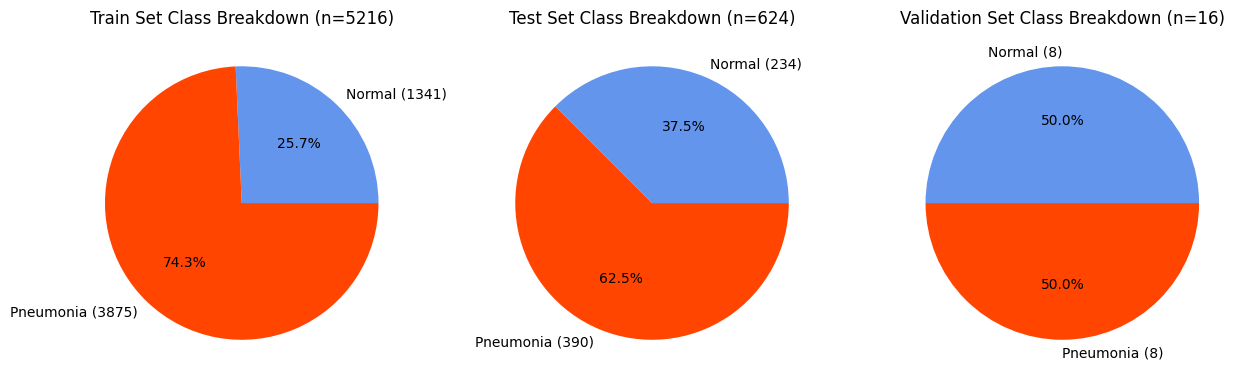

In [4]:
# compare number of images in each category
test_normal_images_count = len(test_generator.classes[test_generator.classes == 0])
test_pneumonia_images_count = len(test_generator.classes[test_generator.classes == 1])

train_normal_images_count = len(train_generator.classes[train_generator.classes == 0])
train_pneumonia_images_count = len(train_generator.classes[train_generator.classes == 1])

validation_normal_images_count = len(validation_generator.classes[validation_generator.classes == 0])
validation_pneumonia_images_count = len(validation_generator.classes[validation_generator.classes == 1])

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax.flatten()

ax[0].pie([train_normal_images_count, train_pneumonia_images_count],
       labels=[f'Normal ({train_normal_images_count})', f'Pneumonia ({train_pneumonia_images_count})'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
ax[0].set_title(f'Train Set Class Breakdown (n={train_normal_images_count + train_pneumonia_images_count})')
ax[1].pie([test_normal_images_count, test_pneumonia_images_count],
       labels=[f'Normal ({test_normal_images_count})', f'Pneumonia ({test_pneumonia_images_count})'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
ax[1].set_title(f'Test Set Class Breakdown (n={test_normal_images_count + test_pneumonia_images_count})')
ax[2].pie([validation_normal_images_count, validation_pneumonia_images_count],
       labels=[f'Normal ({validation_normal_images_count})', f'Pneumonia ({validation_pneumonia_images_count})'],
       colors=['cornflowerblue', 'orangered'],
       autopct='%1.1f%%')
ax[2].set_title(f'Validation Set Class Breakdown (n={validation_normal_images_count + validation_pneumonia_images_count})')

plt.show()

There's a clear skew towards pneumonia images, so we can't rely on accuracy: just classifying all images as pneumonia would give over 62.5% test accuracy! We'll refer to the confusion matrix to see true positives, true negatives, false positives, and false negatives, and draw conclusions from there. 

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Convolutional Neural Nets: First Approach

In [6]:
batch_size = 20
epochs = 15

steps_per_epoch = len(train_generator)//batch_size
validation_steps = len(validation_generator)//batch_size

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    #tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    #tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #tf.keras.metrics.Precision(name='precision'),
    #tf.keras.metrics.Recall(name='recall'),
]

2025-02-11 17:43:45.700060: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
# Using CNN configuration from tensorflow tutorial: https://www.tensorflow.org/tutorials/images/cnn
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(height, width, channels)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        18,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,817 (292.25 KB)

 Trainable params: 74,817 (292.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.9607 - loss: 0.0977 - tn: 37.1111 - tp: 112.4444 - val_accuracy: 0.6875 - val_loss: 0.8689 - val_tn: 3.0000 - val_tp: 8.0000
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.9634 - loss: 0.1130 - tn: 43.0000 - tp: 107.0000 - val_accuracy: 0.6875 - val_loss: 0.6556 - val_tn: 3.0000 - val_tp: 8.0000
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.9406 - loss: 0.1464 - tn: 40.5556 - tp: 106.3333 - val_accuracy: 0.8750 - val_loss: 0.3235 - val_tn: 7.0000 - val_tp: 7.0000
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.9531 - loss: 0.1272 - tn: 26.4444 - tp: 123.3333 - val_accuracy: 0.7500 - val_loss: 0.5261 - val_tn: 4.0000 - val_tp: 8.0000
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9655 - loss: 0.0894 - tn: 30.1111 - tp: 120.8889 - val_accuracy: 0.8750 - val_loss: 0.2792 - val_tn: 7.0000 - val_tp: 7.0000
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step


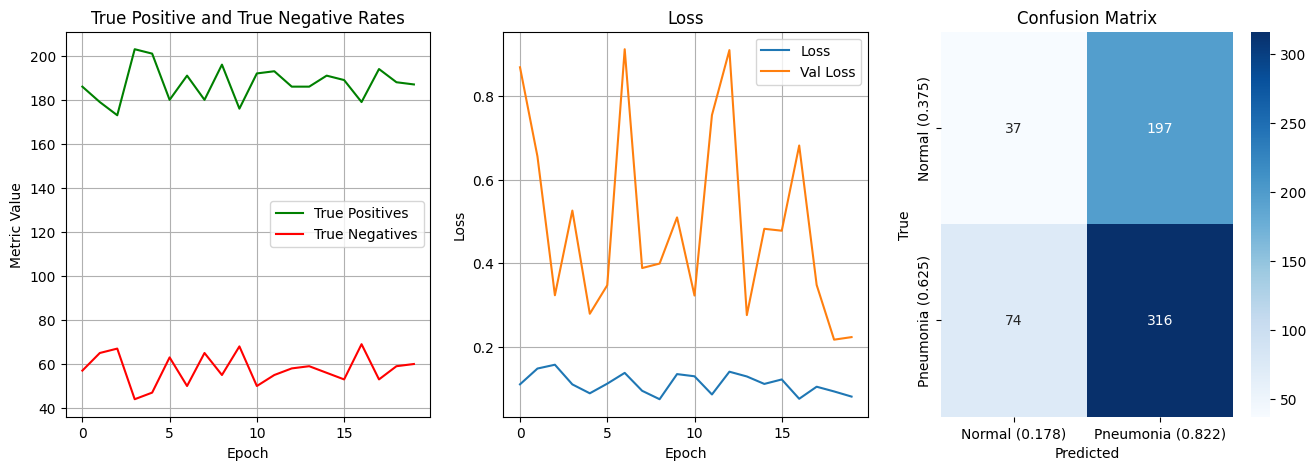

In [26]:
def summary_graphics(history, model, test_model=None):
    if test_model is None:
        test_model = model
    y_pred = np.round(test_model.predict(test_generator))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    #ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    #ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True Positive and True Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()

summary_graphics(history, model_1)

What isn't shown here is the roughly dozen additional models I trained based on the model above, all which had roughly identical performance: an extremely high false positive rate, and a false negative rate that made the positive diagnosis basically 50-50 accuracy. It was obvious my models were bad and that I didn't know how to improve them.

Initially, the problem I thought I had was *overfitting* the unbalanced data: clearly pneumonia images were overrepresented, and I thought that if I could penalize the neural net for training to much on the pneumonia images, I would get a confusion matrix that looked closer to the identity (which means few false positives and few false negatives). I emailed my professor, Dr. Wang, at Northeastern, who told me to try resampling (which unfortunately seems a bit tricky with keras generators) or to create class weights, which I implemented following the [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) on imbalanced data.

In [10]:
# from the tensorflow tutorial on imbalanced data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# output bias
output_bias = tf.keras.initializers.Constant(np.log([train_pneumonia_images_count/train_normal_images_count]))

# class weights

weight_for_normal = (1 / train_normal_images_count)*(train_normal_images_count + train_pneumonia_images_count)/2.0
weight_for_pneumonia = (1 / train_pneumonia_images_count)*(train_normal_images_count + train_pneumonia_images_count)/2.0

class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print(f"Weight for normal class: {weight_for_normal:1.3f}")
print(f"Weight for pneumonia class: {weight_for_pneumonia:1.3f}")

Weight for normal class: 1.945
Weight for pneumonia class: 0.673


Introducing the class weights resulted in marginally better performance, but my false negative/positive rates were still very high. Clearly I had misdiagnosed the problem.

So I consulted two sources: I had a copy of [Hands on Machine Learning with Scikit-Learn, Keras \& TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) by Aurélien Géron and decided to consult that. I also looked at the notebooks on the [kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) for the data set, which brought me to the notebook [Beating Everything with Depthwise Convolution](https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution/notebook) by the user Nain. Both discussed Google's [Xception](https://arxiv.org/abs/1610.02357) neural net that trained with depthwise separable convolution.

I based my model on Nain's, which is based off Xception. There were several things he did that I didn't: he preprocessed his data differently, he 

However, I didn't want to do transfer learning: I wanted to see how good (or bad) a fit I could get just starting from initial weights.

## Convolutional Neural Nets: Second Approach

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(height, width, channels)), # necessary for model summary

    # start with two convolutional layers and then do pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    # the rest of the convolutional layers in the model are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    #tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    #tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    #tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.3conv"),
    #tf.keras.layers.MaxPooling2D((2,2), name="2.4pool"),

    #tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    #tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.2conv"),
    #tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    #tf.keras.layers.MaxPooling2D((2,2), name="3.4pool"),

    # model ends with dense layers with dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', name="4.1dense"),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu', name="4.2dense"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="output")
])

epochs = 20

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 1.1conv (Conv2D)                │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (SeparableConv2D)       │ (None, 75, 75, 128)    │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (SeparableConv2D)       │ (None, 75, 75, 128)    │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3conv (SeparableConv2D)       │ (None, 75, 75, 128)    │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.4pool (MaxPooling2D)          │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1dense (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2dense (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,886,913 (41.53 MB)

 Trainable params: 10,886,913 (41.53 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.4007 - loss: 0.7069 - tn: 29.0000 - tp: 39.8889 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.4088 - loss: 0.6964 - tn: 35.8889 - tp: 28.1111 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.4747 - loss: 0.7043 - tn: 33.1111 - tp: 36.6667 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.4298 - loss: 0.7096 - tn: 33.3333 - tp: 33.1111 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.3900 - loss: 0.6548 - tn: 30.1111 - tp: 33.2222 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


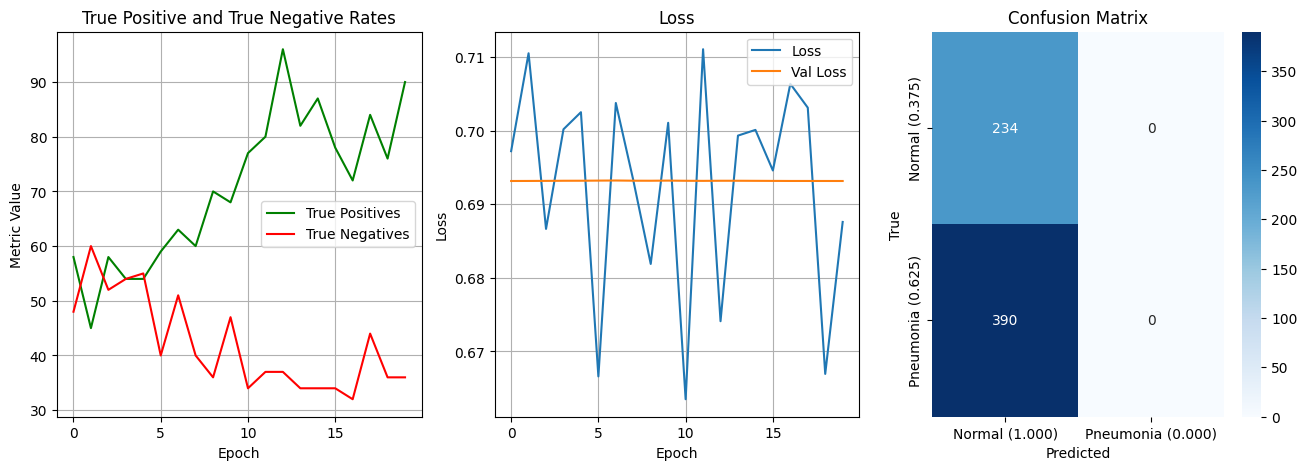

In [13]:
summary_graphics(history, model_2)

## With Transfer Learning from VGG19

Nain's model (and most of the other notebooks on the kaggle page) used transfer learning, which I had been hesitant to try. (Those pretrained models had to have come from somewhere -- why couldn't I just train my own?) But in the interest of making progress and not frying my computer's graphics card, I decided to follow Nain's example and transfer the weights from a VGG model to the first two layers. Nain used VGG16, and since then VGG19 has been released, so I went with VGG19 instead.

In [14]:
# While working, I discovered that the tf.keras.preprocessing.image.ImageDataGenerator class is deprecated
# using this new API instead

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2025-02-11 17:56:44.295223: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# plot some images from the dataset
#fig, ax = plt.subplots(2, 3)


In [16]:
preprocessing_layers = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(height, width, channels)),

], name = "Preprocessing_No_Augmentation")

# I previously considered balancing the data set by adding a new set of augmented images from the minority class, like Nain did
# however, this is apparently bad practice because while the smaller class (here, the normal images class) would have more images,
# it would have less variance, even with our augmentation. This would skew the model!
# https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
augmentation_layers = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2),
    # all the above noise would happen before these images even arrived in the model
    # so do "real" preprocessing here
    tf.keras.layers.Rescaling(1./255),
], name = "Preprocessing_Augmentation")

/home/sam/Documents/projects/ConvolutedPneumoniaDetection/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
vgg19 = tf.keras.applications.VGG16() # default parameters are fine
vgg19.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
initial_layers_pretrained = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(244, 244), # VGG layers expect 244x244 images
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),
], name = "Initial_Pretrained")

In [19]:
initial_layers = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.1conv"),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', name="1.2conv"),
    #tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.4conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.5conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.6pool"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),
], name = "Initial_Non_Pretrained")

core_layers = tf.keras.models.Sequential([
    # the rest of the convolutional layers in Xception are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.2conv"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="3.4pool"),

    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.2conv"),
    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.3conv"),
    #tf.keras.layers.MaxPooling2D((2,2), name="4.4pool"),

    # more convolution layers reduce the number of trainable parameters in the model (but seems to increase training time!)
    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.1conv"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.2conv"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="5.3conv"),
    #tf.keras.layers.MaxPooling2D((2,2), name="5.4pool"),

    # all the CNN models end with dense layers, probably to help the model "interpret" what the convolutional layers see
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', name="6.1dense"),
    # the above dense layer has 3 million of the 5 million trainable parameters!
    # add in a dropout layer with a high rate to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', name="6.2dense"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="output")
], name = "Core")

In [20]:
def build_model(pretrained=False, name="") -> (tf.keras.models.Sequential, tf.keras.models.Sequential):
    models = (
        tf.keras.models.Sequential(name=name+"_Train"),
        tf.keras.models.Sequential(name=name+"_Test")
    )

    for model in models:
        model.add(tf.keras.layers.InputLayer(input_shape=(height, width, channels)))

    # random noise happens before the model even sees the image
    # these layers are the difference between test and train models!
    models[0].add(augmentation_layers)

    for model in models:
        model.add(tf.keras.layers.Rescaling(1./255))
        if pretrained:
            model.add(initial_layers_pretrained)
        else:
            model.add(initial_layers)
        model.add(core_layers)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics
        )

    # loading weights and freezing layers has to be done after compilation
    if pretrained:
        # will apply to both models
        initial_layers_pretrained.get_layer("1.1conv").set_weights(vgg19.get_layer('block1_conv1').get_weights())
        initial_layers_pretrained.get_layer("1.2conv").set_weights(vgg19.get_layer('block1_conv2').get_weights())
        initial_layers_pretrained.get_layer("2.1conv").set_weights(vgg19.get_layer('block2_conv1').get_weights())
        initial_layers_pretrained.get_layer("2.2conv").set_weights(vgg19.get_layer('block2_conv2').get_weights())
        initial_layers_pretrained.get_layer("1.1conv").trainable = False
        initial_layers_pretrained.get_layer("1.2conv").trainable = False
        initial_layers_pretrained.get_layer("2.1conv").trainable = False
        initial_layers_pretrained.get_layer("2.2conv").trainable = False
    return models

In [21]:
pretrained = False
model_3_train, model_3_test = build_model(pretrained=pretrained, name="Model_3")

if pretrained:
    initial_layers_pretrained.summary()
else:
    initial_layers.summary()
core_layers.summary()

Model: "Initial_Non_Pretrained"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 1.4conv (Conv2D)                │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.5conv (Conv2D)                │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.6pool (MaxPooling2D)          │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (SeparableConv2D)       │ (None, 75, 75, 128)    │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (SeparableConv2D)       │ (None, 75, 75, 128)    │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 37, 37, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,280 (255.00 KB)

 Trainable params: 65,280 (255.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Core"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 3.1conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 6.1dense (Dense)                │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 6.2dense (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,769,793 (163.15 MB)

 Trainable params: 42,769,793 (163.15 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 20

history = model_3_train.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3058 - loss: 0.7081 - tn: 50.8889 - tp: 0.6667 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.2651 - loss: 0.7002 - tn: 43.0000 - tp: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.2452 - loss: 0.6827 - tn: 40.1111 - tp: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.2896 - loss: 0.7218 - tn: 48.0000 - tp: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.2487 - loss: 0.6857 - tn: 38.5556 - tp: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


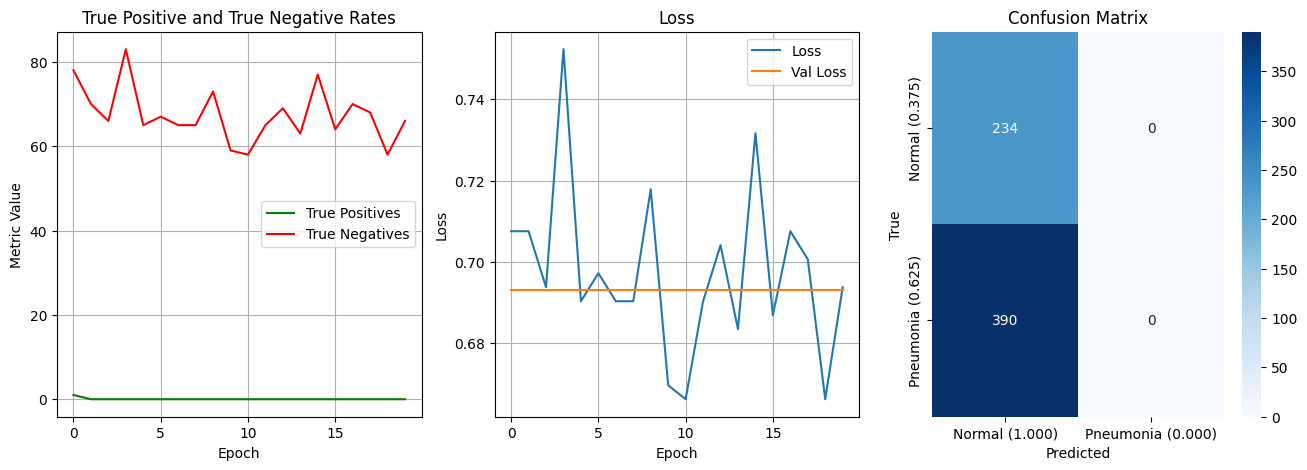

In [23]:
summary_graphics(history, model_3_train, model_3_test)

In [24]:
foo

NameError: name 'foo' is not defined

In [ ]:
# now unfreeze half the layers and train for another 20 epochs
#model_3.get_layer('1.1conv').trainable = False
#model_3.get_layer('1.2conv').trainable = False
#model_3.get_layer('2.1conv').trainable = True
#model_3.get_layer('2.2conv').trainable = True
#
# use a smaller learning rate
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
#model_3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
#
#history2 = model_3.fit(
#    train_generator,
#    validation_data=validation_generator,
#    batch_size = batch_size,
#    steps_per_epoch = steps_per_epoch,
#    validation_steps = validation_steps,
#    epochs=epochs,
#    class_weight=class_weight,
#    verbose=1)
#summary_graphics(history2, model_3)

In [ ]:
# now unfreeze all the layers and train for another 20 epochs
#model_3.get_layer('1.1conv').trainable = True
#model_3.get_layer('1.2conv').trainable = True
#
#model_3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
#
#history3 = model_3.fit(
#    train_generator,
#    validation_data=validation_generator,
#    batch_size = batch_size,
#    steps_per_epoch = steps_per_epoch,
#    validation_steps = validation_steps,
#    epochs=epochs,
#    class_weight=class_weight,
#    verbose=1)
#summary_graphics(history3, model_3)

## Conclusion

In [ ]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")